In [1]:
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


tsai       : 0.2.15
fastai     : 2.2.5
fastcore   : 1.3.19
torch      : 1.7.1+cu101


# 0. load data

In [2]:
input_fn = 'F:\\Github\\kaggle drought\\data_ndarray.npz'

In [3]:
data = np.load(open(input_fn, 'rb'))

In [4]:
X_train = data['X_train']

In [5]:
X_train.shape

(118024, 90, 18)

In [6]:
print(np.mean(X_train.flatten()))

1.1619668e-07


In [7]:
print(np.std(X_train.flatten()))

1.0000005


In [8]:
X_valid = data['X_valid']

In [9]:
X_test = data['X_test']

In [10]:
y_train = data['y_train']
y_train = np.array([int(i) for i in y_train])

In [11]:
y_valid = data['y_valid']
y_valid = np.array([int(i) for i in y_valid])

In [12]:
y_test = data['y_test']
y_test = np.array([int(i) for i in y_test])

We need to exchange two axes：
* **number of samples**
* **number of features** (aka variables, dimensions, channels)
* **number of steps** (or length, time steps, sequence steps)

In [13]:
X_train = X_train.transpose(0, 2, 1)
X_train.shape

(118024, 18, 90)

In [14]:
X_valid = X_valid.transpose(0, 2, 1)
X_valid.shape

(20721, 18, 90)

In [15]:
X_test = X_test.transpose(0, 2, 1)
X_test.shape

(102430, 18, 90)

We already have the split:

In [16]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [17]:
X.shape

(138745, 18, 90)

In [18]:
y.shape

(138745,)

In [19]:
splits

((#118024) [0,1,2,3,4,5,6,7,8,9...],
 (#20721) [118024,118025,118026,118027,118028,118029,118030,118031,118032,118033...])

In [20]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dsets

(#138745) [(TSTensor(vars:18, len:90), TensorCategory(2, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(1, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(2, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(1, dtype=torch.int32))...]

# 1. Model and Hyperparameter Tuning

In [21]:
import hyperopt
print(hyperopt.__version__)

0.2.5


In [22]:
from hyperopt import Trials, STATUS_OK, STATUS_FAIL, tpe, fmin, hp

In [23]:
search_space = {
    'batch_size': hp.choice('bs', [256, 512, 1024]),
    'time_steps': hp.choice('ts', [30, 60, 90]),  # lookback window size
    "lr": hp.choice('lr', [0.1, 0.01, 0.001, 0.0001]),
    "epochs": hp.choice('epochs', [10, 50, 100]),  # we would also use early stopping
    "patience": hp.choice('patience', [5, 10]),  # early stopping patience
    "optimizer": hp.choice('optimizer', [Adam, SGD, RMSProp]),  # https://docs.fast.ai/optimizer
    # model parameters
    "rnn_layers": hp.choice('rnn_layers', [1, 2, 3, 4, 5]),
    "hidden_size": hp.choice('hidden_size', [50, 100, 200]),
    "bidirectional": hp.choice('bidirectional', [True, False]),
    "conv_layers": hp.choice('conv_layers', [[64, 128, 64], [128, 256, 128], [256, 512, 256]]),
    "kss": hp.choice('kss', [[11, 9, 7], [9, 7, 5], [7, 5, 3]])
}

In [24]:
search_space

{'batch_size': <hyperopt.pyll.base.Apply at 0x29b5d14f788>,
 'time_steps': <hyperopt.pyll.base.Apply at 0x29b5d14fdc8>,
 'lr': <hyperopt.pyll.base.Apply at 0x29b5d15b548>,
 'epochs': <hyperopt.pyll.base.Apply at 0x29b5d15bb48>,
 'patience': <hyperopt.pyll.base.Apply at 0x29b5d143108>,
 'optimizer': <hyperopt.pyll.base.Apply at 0x29b5d143708>,
 'rnn_layers': <hyperopt.pyll.base.Apply at 0x29b5d143f48>,
 'hidden_size': <hyperopt.pyll.base.Apply at 0x29b5d147508>,
 'bidirectional': <hyperopt.pyll.base.Apply at 0x29b5d147a88>,
 'conv_layers': <hyperopt.pyll.base.Apply at 0x29b5d14d848>,
 'kss': <hyperopt.pyll.base.Apply at 0x29b5d152588>}

In [25]:
X.shape

(138745, 18, 90)

In [26]:
time_steps = 30

In [27]:
X[:, :, -time_steps:].shape

(138745, 18, 30)

In [28]:
X_test[:, :, -time_steps:].shape

(102430, 18, 30)

In [29]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [30]:
import time
from fastai.callback.tracker import EarlyStoppingCallback

In [31]:
import gc

In [32]:
# clear memory 
gc.collect()

183

In [33]:
def create_model_hypopt(params):
    
    try:
        # clear memory 
        gc.collect()
        print("Trying params:",params)
        batch_size = params["batch_size"]
        time_steps = params["time_steps"]
    
        # Create data loader
        tfms  = [None, [Categorize()]]
        dsets = TSDatasets(X[:, :, -time_steps:], y, tfms=tfms, splits=splits, inplace=True)
        # set num_workers for memory bottleneck
        dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
        # Create model
        arch = RNN_FCN
        k = {
            'rnn_layers': params['rnn_layers'],
            'hidden_size': params['hidden_size'],
            'bidirectional': params['bidirectional'],
            'conv_layers': params['conv_layers'],
            'kss': params['kss']
        }
        model = create_model(arch, dls=dls, **k)
        print(model.__class__.__name__)
    
        # Training the model
        learn = Learner(dls, model, metrics=accuracy, opt_func=params['optimizer'])
        start = time.time()
        learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                            cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
        learn.plot_metrics()
        elapsed = time.time() - start
    
        vals = learn.recorder.values[-1]
        # vals[0], vals[1], vals[2]
        # train loss, valid loss, accuracy
        val_loss = vals[1]
    
        # delete tmp variables
        del dls
        del model
        del learn
        return {'loss': val_loss, 'status': STATUS_OK} # if accuracy use '-' sign, model is optional
    except:
        return {'loss': None, 'status': STATUS_FAIL}

Search the parameters:

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': False, 'conv_layers': (64, 128, 64), 'epochs': 100, 'hidden_size': 200, 'kss': (9, 7, 5), 'lr': 0.001, 'optimizer': <function SGD at 0x0000029B1CFDD0D8>, 'patience': 5, 'rnn_layers': 2, 'time_steps': 60}
RNN_FCN                                                                                                                
  0%|                                                                           | 0/30 [00:28<?, ?trial/s, best loss=?]

epoch,train_loss,valid_loss,accuracy,time
0,1.705155,1.668494,0.535447,00:05
1,1.639506,1.597300,0.644708,00:04
2,1.561816,1.516474,0.664205,00:04
3,1.478027,1.426144,0.664543,00:04
4,1.389717,1.337888,0.664543,00:04
5,1.312036,1.259260,0.664543,00:04
6,1.255681,1.198117,0.664543,00:04
7,1.207624,1.158572,0.664543,00:04
8,1.180638,1.134071,0.664543,00:04
9,1.165051,1.116877,0.664543,00:04


No improvement since epoch 67: early stopping                                                                          
  0%|                                                                           | 0/30 [05:49<?, ?trial/s, best loss=?]

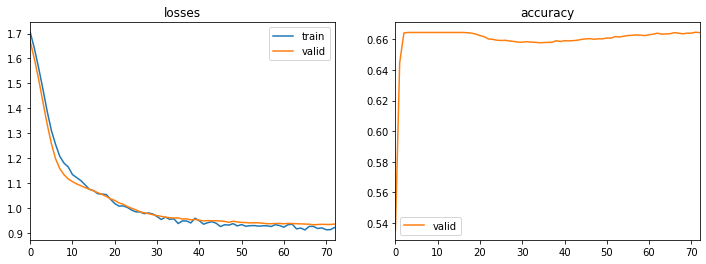

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': True, 'conv_layers': (256, 512, 256), 'epochs': 10, 'hidden_size': 200, 'kss': (7, 5, 3), 'lr': 0.001, 'optimizer': <function Adam at 0x0000029B1CFDD438>, 'patience': 5, 'rnn_layers': 4, 'time_steps': 60}
RNN_FCN                                                                                                                
  3%|█▌                                            | 1/30 [06:15<2:49:06, 349.87s/trial, best loss: 0.9362655282020569]

epoch,train_loss,valid_loss,accuracy,time
0,0.920910,0.880608,0.678056,00:16
1,0.845866,0.892783,0.675643,00:16
2,0.776112,1.047656,0.647749,00:16
3,0.696174,1.109391,0.684137,00:17
4,0.626905,1.213189,0.667825,00:17
5,0.549176,1.138866,0.578930,00:17


No improvement since epoch 0: early stopping                                                                           
  3%|█▌                                            | 1/30 [07:57<2:49:06, 349.87s/trial, best loss: 0.9362655282020569]

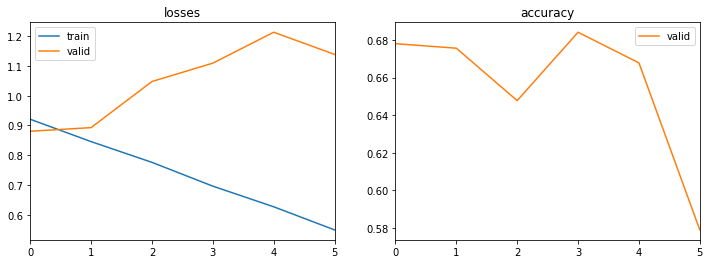

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 100, 'hidden_size': 50, 'kss': (7, 5, 3), 'lr': 0.01, 'optimizer': <function RMSProp at 0x0000029B1CFDD1F8>, 'patience': 10, 'rnn_layers': 1, 'time_steps': 60}
RNN_FCN                                                                                                                
  7%|███                                           | 2/30 [08:23<2:12:10, 283.23s/trial, best loss: 0.9362655282020569]

epoch,train_loss,valid_loss,accuracy,time
0,0.948519,0.947493,0.663626,00:04
1,0.893600,0.916422,0.673616,00:03
2,0.867243,0.881736,0.683123,00:03
3,0.857490,0.933561,0.666956,00:03
4,0.845618,0.910807,0.685102,00:04
5,0.836994,0.925228,0.672506,00:03
6,0.822428,0.928961,0.681820,00:04
7,0.814821,0.994758,0.669031,00:04
8,0.822487,0.964820,0.642054,00:04
9,0.783067,0.881657,0.683413,00:04


No improvement since epoch 9: early stopping                                                                           
  7%|███                                           | 2/30 [09:45<2:12:10, 283.23s/trial, best loss: 0.9362655282020569]

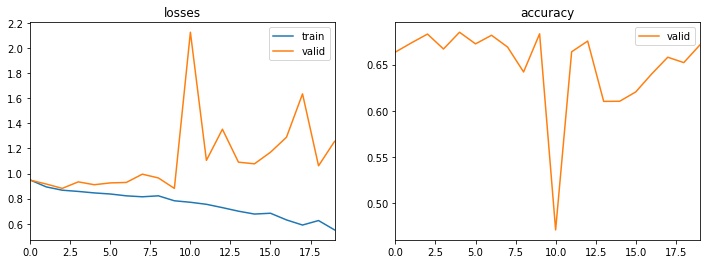

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': True, 'conv_layers': (256, 512, 256), 'epochs': 50, 'hidden_size': 100, 'kss': (9, 7, 5), 'lr': 0.0001, 'optimizer': <function RMSProp at 0x0000029B1CFDD1F8>, 'patience': 10, 'rnn_layers': 4, 'time_steps': 90}
RNN_FCN                                                                                                                
 10%|████▌                                         | 3/30 [10:10<1:43:47, 230.66s/trial, best loss: 0.9362655282020569]

epoch,train_loss,valid_loss,accuracy,time
0,1.201411,1.157650,0.629362,00:22
1,0.994138,0.968502,0.655181,00:22
2,0.932215,0.932995,0.663964,00:23
3,0.901302,0.895779,0.669707,00:23
4,0.854901,0.853721,0.686888,00:24
5,0.840948,0.843252,0.688191,00:24
6,0.822916,0.851183,0.682786,00:24
7,0.796104,0.849440,0.685826,00:24
8,0.769058,0.846799,0.690652,00:24
9,0.757234,0.860372,0.687612,00:24


No improvement since epoch 11: early stopping                                                                          
 10%|████▌                                         | 3/30 [19:07<1:43:47, 230.66s/trial, best loss: 0.9362655282020569]

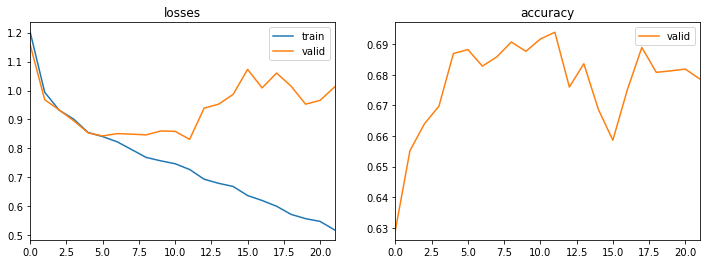

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': True, 'conv_layers': (64, 128, 64), 'epochs': 10, 'hidden_size': 100, 'kss': (9, 7, 5), 'lr': 0.1, 'optimizer': <function Adam at 0x0000029B1CFDD438>, 'patience': 10, 'rnn_layers': 5, 'time_steps': 90}
RNN_FCN                                                                                                                
 13%|██████▏                                       | 4/30 [19:32<2:22:59, 329.97s/trial, best loss: 0.9362655282020569]

epoch,train_loss,valid_loss,accuracy,time
0,0.994104,0.911714,0.667921,00:04
1,1.373990,1.118262,0.655905,00:04
2,1.477624,1.396260,0.578061,00:04
3,1.194290,1.175415,0.659428,00:04
4,1.018646,1.279693,0.627190,00:04
5,0.878792,1.249553,0.681772,00:04
6,0.760899,1.265459,0.683896,00:04
7,0.654657,1.289808,0.666088,00:04
8,0.562167,1.285308,0.674340,00:05
9,0.508536,1.308217,0.674292,00:04


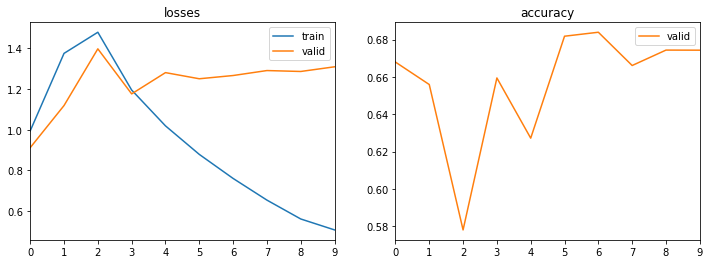

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': False, 'conv_layers': (128, 256, 128), 'epochs': 50, 'hidden_size': 100, 'kss': (9, 7, 5), 'lr': 0.1, 'optimizer': <function SGD at 0x0000029B1CFDD0D8>, 'patience': 10, 'rnn_layers': 5, 'time_steps': 90}
RNN_FCN                                                                                                                
 17%|███████▋                                      | 5/30 [20:48<1:45:36, 253.44s/trial, best loss: 0.9362655282020569]

epoch,train_loss,valid_loss,accuracy,time
0,1.198851,1.123952,0.664543,00:07
1,1.098418,1.095925,0.664543,00:06
2,1.040009,1.053967,0.661937,00:07
3,0.988062,0.996248,0.656870,00:07
4,0.948179,0.959269,0.656773,00:07
5,0.922318,0.938362,0.661261,00:07
6,0.903870,0.938388,0.666570,00:07
7,0.902156,0.931306,0.672603,00:07
8,0.887300,0.887473,0.679842,00:07
9,0.871883,0.889116,0.681386,00:07


No improvement since epoch 14: early stopping                                                                          
 17%|███████▋                                      | 5/30 [24:01<1:45:36, 253.44s/trial, best loss: 0.9362655282020569]

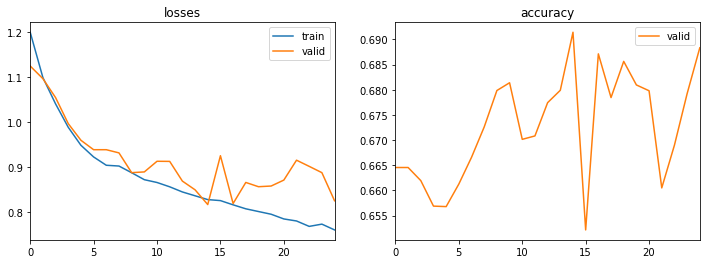

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': False, 'conv_layers': (64, 128, 64), 'epochs': 10, 'hidden_size': 100, 'kss': (9, 7, 5), 'lr': 0.01, 'optimizer': <function Adam at 0x0000029B1CFDD438>, 'patience': 10, 'rnn_layers': 4, 'time_steps': 30}
RNN_FCN                                                                                                                
 20%|█████████▏                                    | 6/30 [24:26<1:37:15, 243.16s/trial, best loss: 0.8251384496688843]

epoch,train_loss,valid_loss,accuracy,time
0,1.016797,0.967415,0.661551,00:02
1,0.932894,0.941995,0.671879,00:02
2,0.907809,0.934077,0.679021,00:02
3,0.867935,0.954511,0.668549,00:02
4,0.819547,1.007117,0.679070,00:02
5,0.763436,1.017647,0.656194,00:02
6,0.706985,1.007000,0.661889,00:02
7,0.654012,1.151224,0.665171,00:02
8,0.608290,1.176184,0.656242,00:02
9,0.587447,1.167667,0.653395,00:02


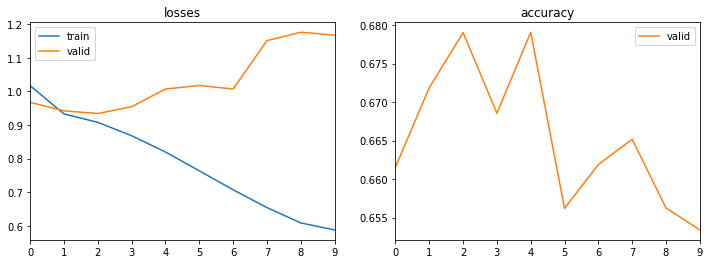

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': True, 'conv_layers': (256, 512, 256), 'epochs': 10, 'hidden_size': 100, 'kss': (9, 7, 5), 'lr': 0.1, 'optimizer': <function RMSProp at 0x0000029B1CFDD1F8>, 'patience': 5, 'rnn_layers': 3, 'time_steps': 60}
RNN_FCN                                                                                                                
 23%|██████████▋                                   | 7/30 [25:14<1:10:44, 184.56s/trial, best loss: 0.8251384496688843]

epoch,train_loss,valid_loss,accuracy,time
0,2.743610,1.970335,0.623908,00:16
1,6.847632,10.531615,0.487718,00:16
2,6.695560,7.272028,0.557116,00:16
3,5.960862,7.497826,0.491916,00:16
4,3.951882,3.928656,0.544327,00:16
5,2.823882,2.551320,0.670431,00:16


No improvement since epoch 0: early stopping                                                                           
 23%|██████████▋                                   | 7/30 [26:52<1:10:44, 184.56s/trial, best loss: 0.8251384496688843]

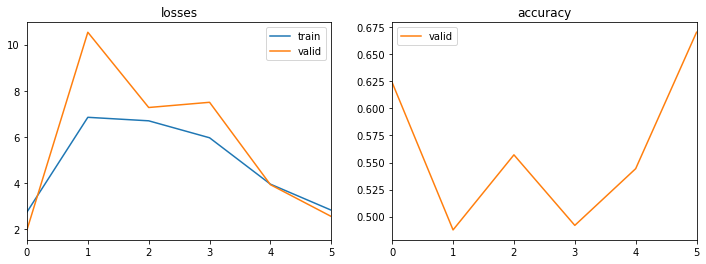

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': False, 'conv_layers': (256, 512, 256), 'epochs': 50, 'hidden_size': 100, 'kss': (11, 9, 7), 'lr': 0.001, 'optimizer': <function RMSProp at 0x0000029B1CFDD1F8>, 'patience': 10, 'rnn_layers': 1, 'time_steps': 60}
RNN_FCN                                                                                                                
 27%|████████████▎                                 | 8/30 [27:18<1:00:57, 166.27s/trial, best loss: 0.8251384496688843]

epoch,train_loss,valid_loss,accuracy,time
0,0.931795,0.908303,0.670672,00:15
1,0.882243,0.930419,0.659090,00:16
2,0.842383,0.911736,0.674051,00:16
3,0.800257,0.873155,0.675691,00:16
4,0.775052,0.942100,0.655856,00:17
5,0.722777,1.364306,0.674099,00:17
6,0.672045,0.954263,0.664640,00:17
7,0.612915,1.370654,0.508470,00:17
8,0.589004,1.450161,0.660296,00:17
9,0.519259,1.483759,0.655760,00:17


No improvement since epoch 3: early stopping                                                                           
 27%|████████████▎                                 | 8/30 [31:18<1:00:57, 166.27s/trial, best loss: 0.8251384496688843]

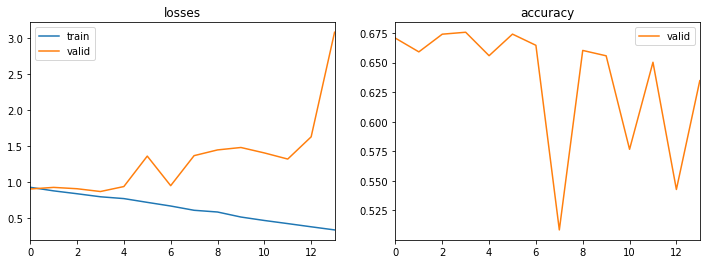

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': True, 'conv_layers': (256, 512, 256), 'epochs': 10, 'hidden_size': 100, 'kss': (11, 9, 7), 'lr': 0.1, 'optimizer': <function Adam at 0x0000029B1CFDD438>, 'patience': 5, 'rnn_layers': 1, 'time_steps': 90}
RNN_FCN                                                                                                                
 30%|█████████████▊                                | 9/30 [31:44<1:08:40, 196.19s/trial, best loss: 0.8251384496688843]

epoch,train_loss,valid_loss,accuracy,time
0,0.989315,0.910094,0.668163,00:18
1,1.224181,1.402594,0.577240,00:18
2,1.383411,1.568593,0.558371,00:19
3,1.204335,1.334620,0.670817,00:19
4,1.076178,1.230792,0.651947,00:19
5,0.903887,1.150576,0.672603,00:19


No improvement since epoch 0: early stopping                                                                           
 30%|█████████████▊                                | 9/30 [33:41<1:08:40, 196.19s/trial, best loss: 0.8251384496688843]

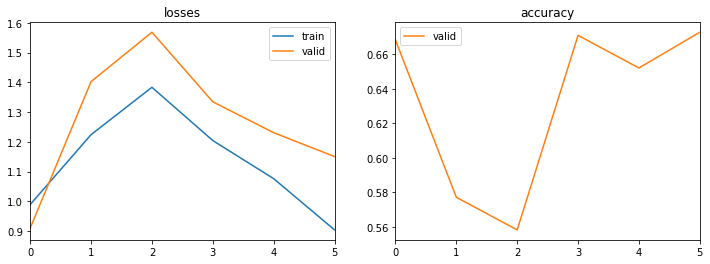

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': False, 'conv_layers': (256, 512, 256), 'epochs': 100, 'hidden_size': 100, 'kss': (11, 9, 7), 'lr': 0.0001, 'optimizer': <function Adam at 0x0000029B1CFDD438>, 'patience': 10, 'rnn_layers': 5, 'time_steps': 30}
RNN_FCN                                                                                                                
 33%|███████████████                              | 10/30 [34:06<1:00:02, 180.14s/trial, best loss: 0.8251384496688843]

epoch,train_loss,valid_loss,accuracy,time
0,1.264323,1.250960,0.615559,00:10
1,1.057823,1.021704,0.656629,00:10
2,0.993271,0.972863,0.661648,00:11
3,0.966156,0.970061,0.663530,00:11
4,0.947364,0.950863,0.667391,00:11
5,0.918898,0.942501,0.671734,00:11
6,0.905643,0.964516,0.664350,00:11
7,0.877118,0.920474,0.675691,00:11
8,0.861364,0.918859,0.673327,00:11
9,0.840468,0.912135,0.677236,00:11


No improvement since epoch 9: early stopping                                                                           
 33%|███████████████                              | 10/30 [37:55<1:00:02, 180.14s/trial, best loss: 0.8251384496688843]

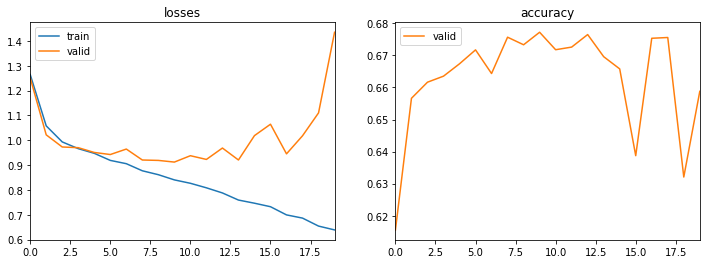

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': True, 'conv_layers': (256, 512, 256), 'epochs': 50, 'hidden_size': 100, 'kss': (7, 5, 3), 'lr': 0.1, 'optimizer': <function Adam at 0x0000029B1CFDD438>, 'patience': 5, 'rnn_layers': 2, 'time_steps': 90}
RNN_FCN                                                                                                                
 37%|████████████████▌                            | 11/30 [38:21<1:04:07, 202.51s/trial, best loss: 0.8251384496688843]

epoch,train_loss,valid_loss,accuracy,time
0,0.906452,0.885432,0.682834,00:16
1,0.862345,0.873367,0.688432,00:16
2,0.876049,1.082463,0.673954,00:16
3,0.871007,1.074501,0.665171,00:17
4,0.858482,1.154800,0.676270,00:17
5,0.849198,1.194496,0.630037,00:17
6,0.843336,1.365880,0.593745,00:17


No improvement since epoch 1: early stopping                                                                           
 37%|████████████████▌                            | 11/30 [40:20<1:04:07, 202.51s/trial, best loss: 0.8251384496688843]

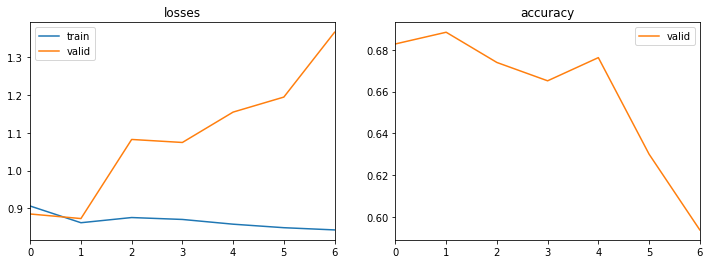

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': False, 'conv_layers': (256, 512, 256), 'epochs': 50, 'hidden_size': 50, 'kss': (9, 7, 5), 'lr': 0.1, 'optimizer': <function Adam at 0x0000029B1CFDD438>, 'patience': 10, 'rnn_layers': 5, 'time_steps': 60}
RNN_FCN                                                                                                                
 40%|██████████████████▊                            | 12/30 [40:46<55:33, 185.19s/trial, best loss: 0.8251384496688843]

epoch,train_loss,valid_loss,accuracy,time
0,0.892983,0.866940,0.683558,00:14
1,0.853932,0.889879,0.685681,00:14
2,0.824949,0.968653,0.669128,00:15
3,0.782294,1.010510,0.644177,00:15
4,0.746902,1.286639,0.678346,00:15
5,0.724045,1.140994,0.639930,00:15
6,0.718377,1.343650,0.635973,00:15
7,0.696441,1.080709,0.643888,00:15
8,0.680705,1.378678,0.649196,00:15
9,0.680904,1.634101,0.658993,00:15


No improvement since epoch 0: early stopping                                                                           
 40%|██████████████████▊                            | 12/30 [43:34<55:33, 185.19s/trial, best loss: 0.8251384496688843]

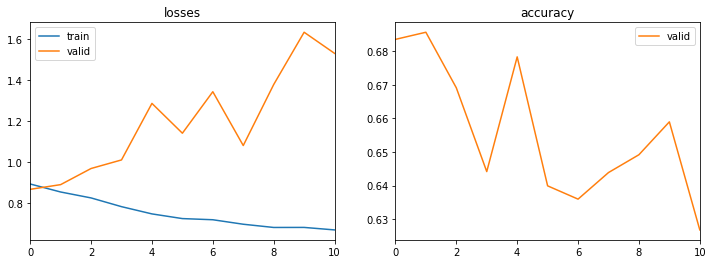

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': False, 'conv_layers': (128, 256, 128), 'epochs': 100, 'hidden_size': 100, 'kss': (9, 7, 5), 'lr': 0.01, 'optimizer': <function SGD at 0x0000029B1CFDD0D8>, 'patience': 5, 'rnn_layers': 5, 'time_steps': 30}
RNN_FCN                                                                                                                
 43%|████████████████████▎                          | 13/30 [43:59<53:10, 187.68s/trial, best loss: 0.8251384496688843]

epoch,train_loss,valid_loss,accuracy,time
0,1.249542,1.184008,0.664543,00:06
1,1.148082,1.111286,0.664543,00:06
2,1.106556,1.091833,0.664543,00:06
3,1.081203,1.082108,0.664398,00:06
4,1.058981,1.071416,0.662758,00:06
5,1.033866,1.056008,0.660875,00:06
6,1.021772,1.037856,0.659910,00:06
7,1.003761,1.017528,0.660007,00:06
8,0.991199,1.002821,0.659428,00:06
9,0.976943,0.989273,0.659765,00:06


No improvement since epoch 34: early stopping                                                                          
 43%|████████████████████▎                          | 13/30 [48:06<53:10, 187.68s/trial, best loss: 0.8251384496688843]

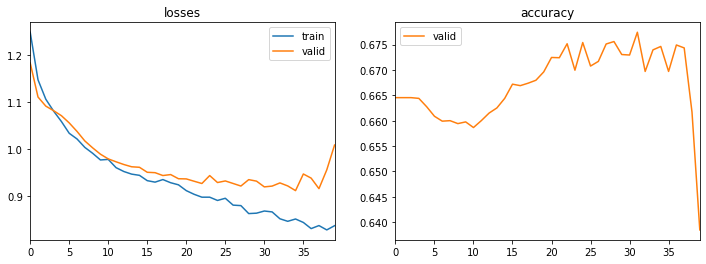

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': False, 'conv_layers': (256, 512, 256), 'epochs': 10, 'hidden_size': 100, 'kss': (11, 9, 7), 'lr': 0.001, 'optimizer': <function RMSProp at 0x0000029B1CFDD1F8>, 'patience': 5, 'rnn_layers': 3, 'time_steps': 90}
RNN_FCN                                                                                                                
 47%|█████████████████████▉                         | 14/30 [48:31<56:48, 213.01s/trial, best loss: 0.8251384496688843]

epoch,train_loss,valid_loss,accuracy,time
0,0.947092,1.264827,0.529222,00:19
1,0.869337,0.946673,0.661889,00:20
2,0.814957,0.861434,0.677525,00:21
3,0.754333,1.256514,0.574104,00:21
4,0.682224,1.299695,0.488007,00:21
5,0.611594,0.939753,0.651127,00:21
6,0.542088,1.105063,0.668356,00:21
7,0.483284,1.141586,0.659186,00:21


No improvement since epoch 2: early stopping                                                                           
 47%|█████████████████████▉                         | 14/30 [51:20<56:48, 213.01s/trial, best loss: 0.8251384496688843]

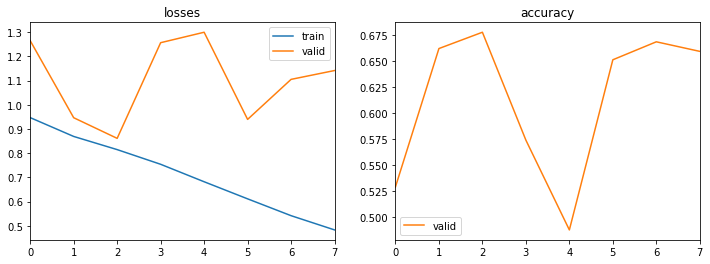

Trying params:                                                                                                         
{'batch_size': 256, 'bidirectional': False, 'conv_layers': (64, 128, 64), 'epochs': 100, 'hidden_size': 100, 'kss': (9, 7, 5), 'lr': 0.001, 'optimizer': <function SGD at 0x0000029B1CFDD0D8>, 'patience': 5, 'rnn_layers': 1, 'time_steps': 60}
RNN_FCN                                                                                                                
 50%|███████████████████████▌                       | 15/30 [51:46<51:50, 207.37s/trial, best loss: 0.8251384496688843]

epoch,train_loss,valid_loss,accuracy,time
0,1.875316,1.824547,0.165146,00:03
1,1.806210,1.749501,0.299406,00:03
2,1.727793,1.662810,0.449737,00:03
3,1.630118,1.561924,0.566334,00:03
4,1.524861,1.455802,0.634622,00:03
5,1.425519,1.355302,0.659379,00:03
6,1.342151,1.273556,0.664205,00:03
7,1.271208,1.213874,0.664495,00:03
8,1.232211,1.171723,0.664543,00:03
9,1.203256,1.144032,0.664543,00:03


No improvement since epoch 72: early stopping                                                                          
 50%|███████████████████████▌                       | 15/30 [56:47<51:50, 207.37s/trial, best loss: 0.8251384496688843]

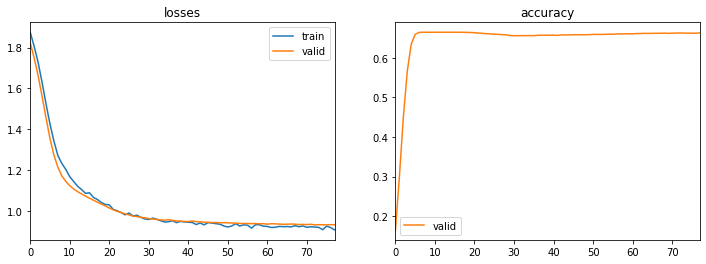

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': False, 'conv_layers': (256, 512, 256), 'epochs': 50, 'hidden_size': 50, 'kss': (11, 9, 7), 'lr': 0.1, 'optimizer': <function SGD at 0x0000029B1CFDD0D8>, 'patience': 10, 'rnn_layers': 2, 'time_steps': 30}
RNN_FCN                                                                                                                
 53%|█████████████████████████                      | 16/30 [57:13<56:45, 243.22s/trial, best loss: 0.8251384496688843]

epoch,train_loss,valid_loss,accuracy,time
0,1.129158,1.083244,0.662227,00:08
1,1.043517,1.048696,0.657497,00:08
2,1.003528,1.015585,0.657063,00:08
3,0.975030,0.987824,0.658318,00:08
4,0.956171,0.971900,0.661213,00:08
5,0.942990,0.973395,0.657352,00:08
6,0.933138,0.955909,0.664736,00:08
7,0.923065,0.968330,0.647411,00:08
8,0.911680,0.965531,0.659524,00:08
9,0.904718,0.954417,0.664350,00:08


No improvement since epoch 14: early stopping                                                                          
 53%|████████████████████████                     | 16/30 [1:00:47<56:45, 243.22s/trial, best loss: 0.8251384496688843]

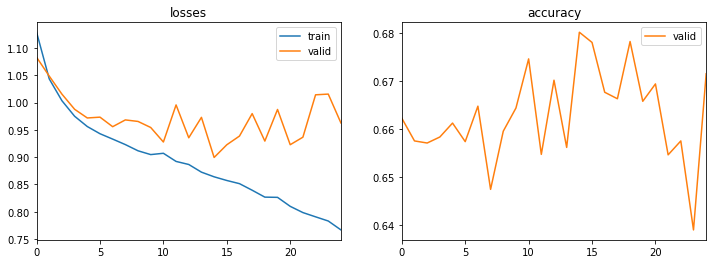

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': True, 'conv_layers': (64, 128, 64), 'epochs': 50, 'hidden_size': 100, 'kss': (9, 7, 5), 'lr': 0.0001, 'optimizer': <function Adam at 0x0000029B1CFDD438>, 'patience': 5, 'rnn_layers': 4, 'time_steps': 90}
RNN_FCN                                                                                                                
 57%|█████████████████████████▌                   | 17/30 [1:01:13<52:30, 242.36s/trial, best loss: 0.8251384496688843]

epoch,train_loss,valid_loss,accuracy,time
0,1.639009,1.572495,0.550987,00:06
1,1.329066,1.225636,0.657256,00:06
2,1.145919,1.098403,0.662130,00:06
3,1.069960,1.053292,0.660393,00:06
4,1.012470,1.004218,0.658800,00:06
5,0.969241,0.969531,0.659283,00:06
6,0.946302,0.946855,0.662130,00:06
7,0.911169,0.913781,0.669176,00:06
8,0.888700,0.910490,0.672217,00:06
9,0.855796,0.871145,0.680324,00:06


No improvement since epoch 15: early stopping                                                                          
 57%|█████████████████████████▌                   | 17/30 [1:03:26<52:30, 242.36s/trial, best loss: 0.8251384496688843]

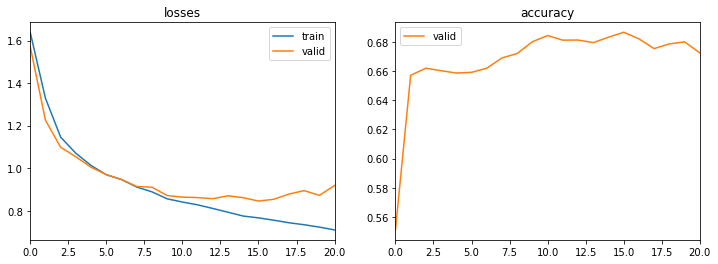

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': True, 'conv_layers': (256, 512, 256), 'epochs': 100, 'hidden_size': 100, 'kss': (7, 5, 3), 'lr': 0.1, 'optimizer': <function RMSProp at 0x0000029B1CFDD1F8>, 'patience': 10, 'rnn_layers': 2, 'time_steps': 60}
RNN_FCN                                                                                                                
 60%|███████████████████████████                  | 18/30 [1:03:51<43:26, 217.18s/trial, best loss: 0.8251384496688843]

epoch,train_loss,valid_loss,accuracy,time
0,0.975621,0.892927,0.671493,00:11
1,0.959049,0.949732,0.666377,00:12
2,0.945827,0.956061,0.655615,00:12
3,0.951206,0.991277,0.668404,00:12
4,0.987292,0.988873,0.656049,00:12
5,1.018159,1.270842,0.651658,00:12
6,1.176787,2.720980,0.553786,00:12
7,1.151507,1.344373,0.652768,00:12
8,1.359362,3.055372,0.602625,00:12
9,1.513500,1.720016,0.613001,00:12


No improvement since epoch 0: early stopping                                                                           
 60%|███████████████████████████                  | 18/30 [1:06:09<43:26, 217.18s/trial, best loss: 0.8251384496688843]

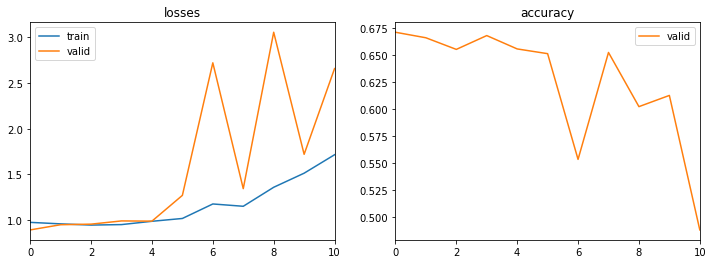

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': False, 'conv_layers': (256, 512, 256), 'epochs': 50, 'hidden_size': 200, 'kss': (9, 7, 5), 'lr': 0.01, 'optimizer': <function Adam at 0x0000029B1CFDD438>, 'patience': 5, 'rnn_layers': 4, 'time_steps': 30}
RNN_FCN                                                                                                                
 63%|████████████████████████████▌                | 19/30 [1:06:35<36:52, 201.16s/trial, best loss: 0.8251384496688843]

epoch,train_loss,valid_loss,accuracy,time
0,0.955911,0.954957,0.671686,00:08
1,0.899463,0.936706,0.673616,00:08
2,0.857464,0.918407,0.671975,00:08
3,0.815154,1.070742,0.628879,00:08
4,0.779064,1.325363,0.672699,00:08
5,0.733970,1.188975,0.575696,00:09
6,0.698207,1.142717,0.647411,00:09
7,0.657837,1.242726,0.646880,00:09


No improvement since epoch 2: early stopping                                                                           
 63%|████████████████████████████▌                | 19/30 [1:07:46<36:52, 201.16s/trial, best loss: 0.8251384496688843]

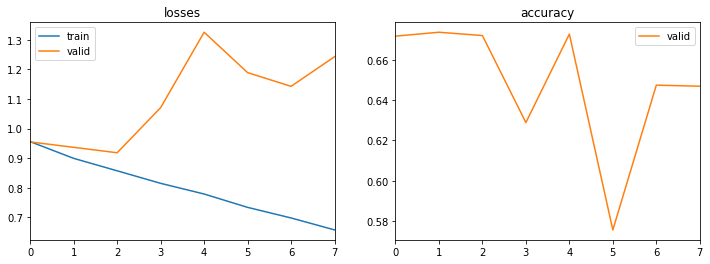

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 50, 'hidden_size': 50, 'kss': (9, 7, 5), 'lr': 0.0001, 'optimizer': <function SGD at 0x0000029B1CFDD0D8>, 'patience': 5, 'rnn_layers': 4, 'time_steps': 90}
RNN_FCN                                                                                                                
 67%|██████████████████████████████               | 20/30 [1:08:12<28:17, 169.79s/trial, best loss: 0.8251384496688843]

epoch,train_loss,valid_loss,accuracy,time
0,1.709842,1.691231,0.401235,00:07
1,1.698969,1.680474,0.429226,00:07
2,1.683280,1.661826,0.474494,00:08
3,1.658124,1.633327,0.535109,00:08
4,1.622084,1.591959,0.601371,00:08
5,1.573181,1.540999,0.644612,00:08
6,1.521422,1.482933,0.660827,00:08
7,1.463831,1.423108,0.664447,00:08
8,1.409537,1.364731,0.664495,00:08
9,1.360900,1.313347,0.664543,00:08


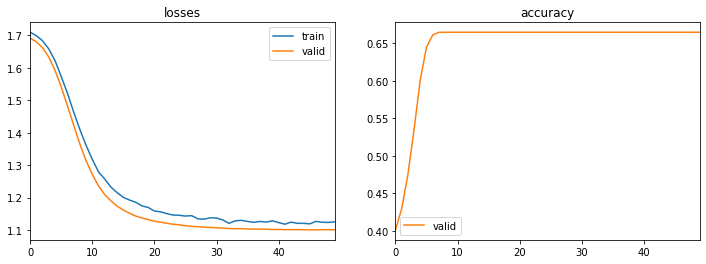

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 50, 'hidden_size': 200, 'kss': (9, 7, 5), 'lr': 0.0001, 'optimizer': <function SGD at 0x0000029B1CFDD0D8>, 'patience': 10, 'rnn_layers': 5, 'time_steps': 90}
RNN_FCN                                                                                                                
 70%|███████████████████████████████▍             | 21/30 [1:15:40<38:00, 253.35s/trial, best loss: 0.8251384496688843]

epoch,train_loss,valid_loss,accuracy,time
0,1.682835,1.654431,0.568312,00:11
1,1.671593,1.641131,0.594373,00:12
2,1.651297,1.618270,0.627624,00:12
3,1.620631,1.582500,0.655953,00:13
4,1.576447,1.534017,0.663868,00:13
5,1.523315,1.476682,0.664543,00:13
6,1.463071,1.413512,0.664543,00:13
7,1.405557,1.352395,0.664543,00:13
8,1.349337,1.297173,0.664543,00:13
9,1.308647,1.252839,0.664543,00:13


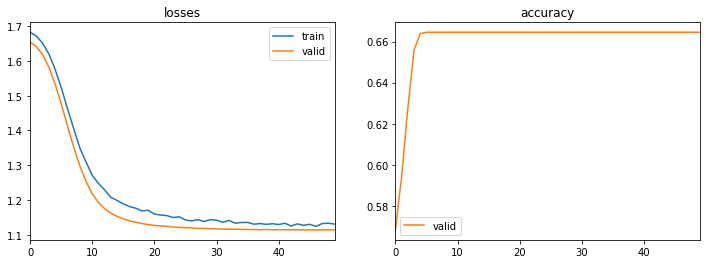

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 50, 'hidden_size': 100, 'kss': (9, 7, 5), 'lr': 0.0001, 'optimizer': <function SGD at 0x0000029B1CFDD0D8>, 'patience': 5, 'rnn_layers': 4, 'time_steps': 90}
RNN_FCN                                                                                                                
 73%|█████████████████████████████████            | 22/30 [1:27:34<52:11, 391.43s/trial, best loss: 0.8251384496688843]

epoch,train_loss,valid_loss,accuracy,time
0,1.868015,1.839685,0.109213,00:08
1,1.855920,1.824919,0.115245,00:08
2,1.834830,1.799267,0.129723,00:09
3,1.799317,1.761075,0.167029,00:09
4,1.751262,1.706420,0.274263,00:09
5,1.689495,1.638734,0.464167,00:09
6,1.615039,1.559737,0.619034,00:09
7,1.538730,1.478873,0.659331,00:09
8,1.462905,1.401587,0.664302,00:09
9,1.396029,1.332391,0.664543,00:09


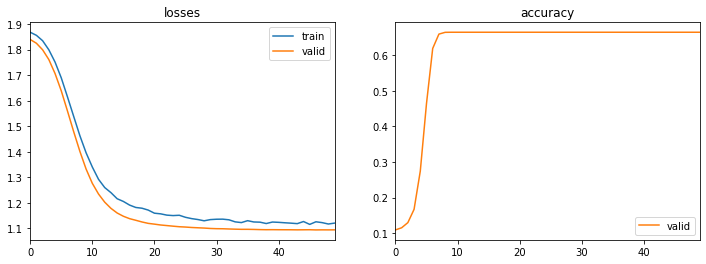

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': False, 'conv_layers': (64, 128, 64), 'epochs': 50, 'hidden_size': 100, 'kss': (9, 7, 5), 'lr': 0.0001, 'optimizer': <function SGD at 0x0000029B1CFDD0D8>, 'patience': 10, 'rnn_layers': 5, 'time_steps': 90}
RNN_FCN                                                                                                                
 77%|██████████████████████████████████▌          | 23/30 [1:36:02<49:44, 426.40s/trial, best loss: 0.8251384496688843]

epoch,train_loss,valid_loss,accuracy,time
0,2.046203,2.050703,0.137879,00:04
1,2.041407,2.042965,0.137879,00:04
2,2.028356,2.027464,0.137879,00:04
3,2.004840,2.002666,0.137879,00:04
4,1.973644,1.966717,0.137879,00:04
5,1.929458,1.918928,0.137879,00:04
6,1.876718,1.860331,0.137879,00:04
7,1.815077,1.794516,0.137879,00:04
8,1.744253,1.720960,0.137879,00:04
9,1.671763,1.647228,0.149172,00:04


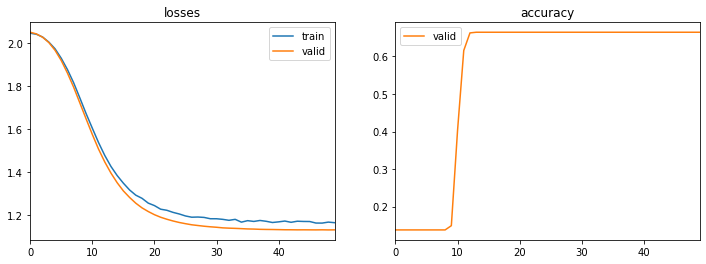

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 50, 'hidden_size': 100, 'kss': (9, 7, 5), 'lr': 0.0001, 'optimizer': <function Adam at 0x0000029B1CFDD438>, 'patience': 10, 'rnn_layers': 3, 'time_steps': 90}
RNN_FCN                                                                                                                
 80%|████████████████████████████████████         | 24/30 [1:40:03<37:04, 370.82s/trial, best loss: 0.8251384496688843]

epoch,train_loss,valid_loss,accuracy,time
0,1.537678,1.503133,0.579509,00:07
1,1.310078,1.253297,0.617248,00:08
2,1.086618,1.032923,0.660248,00:08
3,1.007361,0.991895,0.657883,00:08
4,0.962170,0.960889,0.661648,00:08
5,0.926559,0.935576,0.665315,00:08
6,0.895606,0.900926,0.675354,00:08
7,0.868519,0.876200,0.679697,00:08
8,0.840058,0.867057,0.681241,00:09
9,0.820222,0.841285,0.688577,00:08


No improvement since epoch 9: early stopping                                                                           
 80%|████████████████████████████████████         | 24/30 [1:43:00<37:04, 370.82s/trial, best loss: 0.8251384496688843]

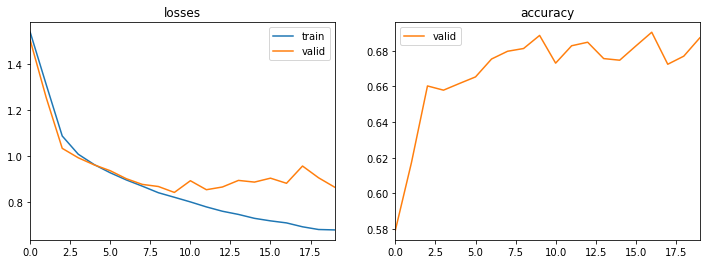

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': False, 'conv_layers': (128, 256, 128), 'epochs': 50, 'hidden_size': 200, 'kss': (9, 7, 5), 'lr': 0.0001, 'optimizer': <function SGD at 0x0000029B1CFDD0D8>, 'patience': 10, 'rnn_layers': 3, 'time_steps': 90}
RNN_FCN                                                                                                                
 83%|█████████████████████████████████████▌       | 25/30 [1:43:26<26:42, 320.58s/trial, best loss: 0.8251384496688843]

epoch,train_loss,valid_loss,accuracy,time
0,1.830476,1.816407,0.067371,00:07
1,1.825002,1.810805,0.070219,00:07
2,1.817132,1.799546,0.079871,00:07
3,1.803984,1.781318,0.102312,00:07
4,1.781921,1.755571,0.165919,00:07
5,1.753088,1.721805,0.306742,00:08
6,1.717959,1.680478,0.485932,00:08
7,1.676678,1.633628,0.606679,00:08
8,1.630909,1.583214,0.650258,00:08
9,1.582520,1.531580,0.662178,00:08


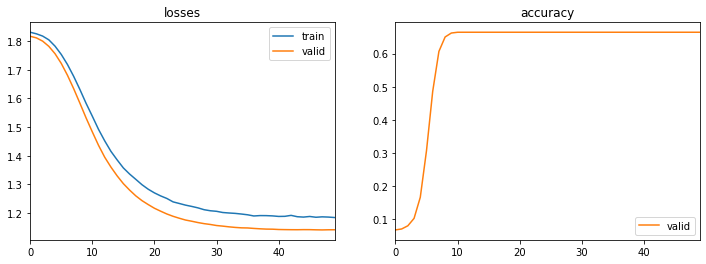

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 50, 'hidden_size': 50, 'kss': (7, 5, 3), 'lr': 0.1, 'optimizer': <function SGD at 0x0000029B1CFDD0D8>, 'patience': 10, 'rnn_layers': 3, 'time_steps': 90}
RNN_FCN                                                                                                                
 87%|███████████████████████████████████████      | 26/30 [1:50:54<23:55, 358.81s/trial, best loss: 0.8251384496688843]

epoch,train_loss,valid_loss,accuracy,time
0,1.209935,1.111544,0.664543,00:05
1,1.111158,1.087943,0.664398,00:05
2,1.056500,1.062717,0.661068,00:06
3,1.012006,1.016000,0.658125,00:06
4,0.967062,0.976285,0.656242,00:06
5,0.931109,0.935691,0.661068,00:06
6,0.915359,0.917439,0.668259,00:06
7,0.897179,0.924767,0.668114,00:06
8,0.887591,0.870356,0.679407,00:06
9,0.883337,0.868891,0.683123,00:06


No improvement since epoch 23: early stopping                                                                          
 87%|███████████████████████████████████████      | 26/30 [1:54:35<23:55, 358.81s/trial, best loss: 0.8251384496688843]

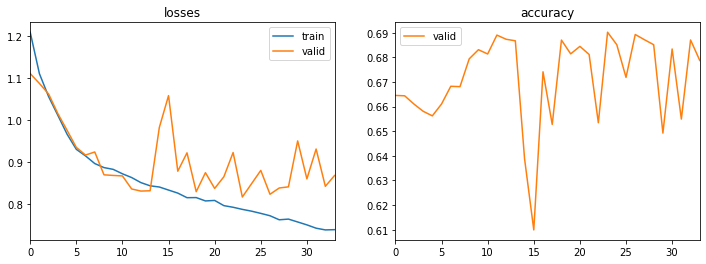

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': False, 'conv_layers': (128, 256, 128), 'epochs': 50, 'hidden_size': 100, 'kss': (9, 7, 5), 'lr': 0.1, 'optimizer': <function Adam at 0x0000029B1CFDD438>, 'patience': 10, 'rnn_layers': 3, 'time_steps': 90}
RNN_FCN                                                                                                                
 90%|████████████████████████████████████████▌    | 27/30 [1:55:01<16:15, 325.17s/trial, best loss: 0.8251384496688843]

epoch,train_loss,valid_loss,accuracy,time
0,0.885366,0.910927,0.663433,00:07
1,0.853673,0.939117,0.664061,00:07
2,0.809569,0.994633,0.665460,00:07
3,0.780676,1.168172,0.675981,00:07
4,0.792359,1.274763,0.663530,00:07
5,0.774778,1.510479,0.684185,00:07
6,0.775977,1.647952,0.642102,00:07
7,0.791985,1.797466,0.676705,00:07
8,0.810797,1.907666,0.622557,00:07
9,0.809955,1.497853,0.627142,00:07


No improvement since epoch 0: early stopping                                                                           
 90%|████████████████████████████████████████▌    | 27/30 [1:56:25<16:15, 325.17s/trial, best loss: 0.8251384496688843]

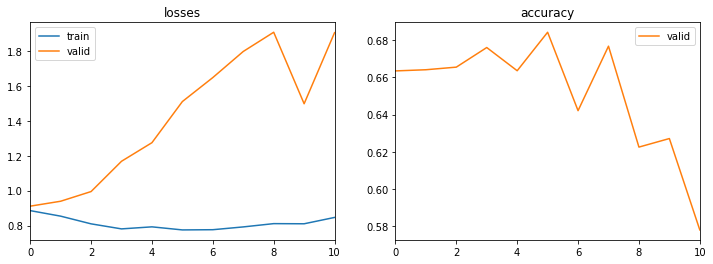

Trying params:                                                                                                         
{'batch_size': 512, 'bidirectional': False, 'conv_layers': (128, 256, 128), 'epochs': 50, 'hidden_size': 200, 'kss': (9, 7, 5), 'lr': 0.0001, 'optimizer': <function SGD at 0x0000029B1CFDD0D8>, 'patience': 10, 'rnn_layers': 3, 'time_steps': 90}
RNN_FCN                                                                                                                
 93%|██████████████████████████████████████████   | 28/30 [1:56:51<08:41, 260.65s/trial, best loss: 0.8251384496688843]

epoch,train_loss,valid_loss,accuracy,time
0,1.735489,1.689320,0.352010,00:07
1,1.726524,1.678604,0.389026,00:07
2,1.710111,1.660221,0.451764,00:08
3,1.684172,1.632223,0.535640,00:08
4,1.649601,1.591273,0.616428,00:08
5,1.605078,1.543241,0.655374,00:08
6,1.552792,1.484745,0.664495,00:08
7,1.495581,1.425696,0.664543,00:08
8,1.441719,1.367529,0.664543,00:08
9,1.391481,1.316480,0.664543,00:08


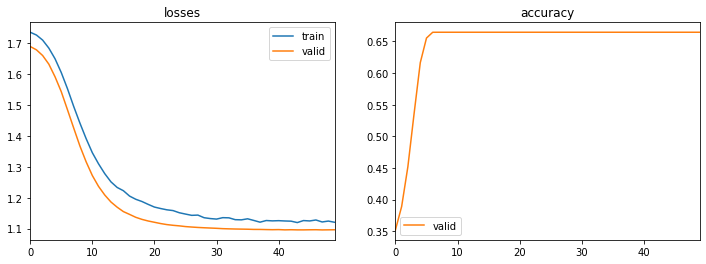

Trying params:                                                                                                         
{'batch_size': 1024, 'bidirectional': True, 'conv_layers': (128, 256, 128), 'epochs': 50, 'hidden_size': 100, 'kss': (9, 7, 5), 'lr': 0.01, 'optimizer': <function Adam at 0x0000029B1CFDD438>, 'patience': 10, 'rnn_layers': 5, 'time_steps': 90}
RNN_FCN                                                                                                                
 97%|███████████████████████████████████████████▌ | 29/30 [2:04:38<05:22, 322.61s/trial, best loss: 0.8251384496688843]

epoch,train_loss,valid_loss,accuracy,time
0,0.952758,0.930468,0.670334,00:08
1,0.863315,0.881260,0.685826,00:08
2,0.803548,0.849197,0.690073,00:08
3,0.755904,0.895068,0.684523,00:08
4,0.719659,1.087174,0.637083,00:09
5,0.698927,1.392425,0.671203,00:09
6,0.732159,1.046546,0.670045,00:09
7,0.698129,0.994567,0.658993,00:09
8,0.653705,1.169653,0.564355,00:09
9,0.613411,1.065754,0.671734,00:09


No improvement since epoch 2: early stopping                                                                           
 97%|███████████████████████████████████████████▌ | 29/30 [2:06:37<05:22, 322.61s/trial, best loss: 0.8251384496688843]

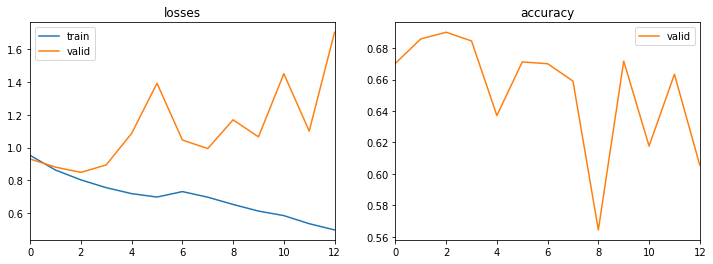

100%|█████████████████████████████████████████████| 30/30 [2:06:37<00:00, 253.25s/trial, best loss: 0.8251384496688843]


In [34]:
trials = Trials()
best = fmin(create_model_hypopt,
    space=search_space,
    algo=tpe.suggest,
    max_evals=30,  # test trials
    trials=trials)

In [35]:
print(best)

{'bidirectional': 1, 'bs': 2, 'conv_layers': 1, 'epochs': 1, 'hidden_size': 1, 'kss': 1, 'lr': 0, 'optimizer': 1, 'patience': 1, 'rnn_layers': 4, 'ts': 2}


In [36]:
from hyperopt import space_eval

In [37]:
print("Best parameters:")
print(space_eval(search_space, best))

Best parameters:
{'batch_size': 1024, 'bidirectional': False, 'conv_layers': (128, 256, 128), 'epochs': 50, 'hidden_size': 100, 'kss': (9, 7, 5), 'lr': 0.1, 'optimizer': <function SGD at 0x0000029B1CFDD0D8>, 'patience': 10, 'rnn_layers': 5, 'time_steps': 90}


In [38]:
best_parameters = space_eval(search_space, best)

In [39]:
def build_model(params):
    # clear memory 
    gc.collect()
    print("Trying params:",params)
    batch_size = params["batch_size"]
    time_steps = params["time_steps"]
    
    # Create data loader
    tfms  = [None, [Categorize()]]
    dsets = TSDatasets(X[:, :, -time_steps:], y, tfms=tfms, splits=splits, inplace=True)
    # set num_workers for memory bottleneck
    dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
    # Create model
    arch = RNN_FCN
    k = {
        'rnn_layers': params['rnn_layers'],
        'hidden_size': params['hidden_size'],
        'bidirectional': params['bidirectional'],
        'conv_layers': params['conv_layers'],
        'kss': params['kss']
    }
    model = create_model(arch, dls=dls, **k)
    print(model.__class__.__name__)
    
    # Training the model
    learn = Learner(dls, model, metrics=accuracy, opt_func=params['optimizer'])
    start = time.time()
    learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                        cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
    learn.plot_metrics()
    elapsed = time.time() - start
    
    # delete tmp variables
    del dls
    del model
    return learn

Trying params: {'batch_size': 1024, 'bidirectional': False, 'conv_layers': (128, 256, 128), 'epochs': 50, 'hidden_size': 100, 'kss': (9, 7, 5), 'lr': 0.1, 'optimizer': <function SGD at 0x0000029B1CFDD0D8>, 'patience': 10, 'rnn_layers': 5, 'time_steps': 90}
RNN_FCN


epoch,train_loss,valid_loss,accuracy,time
0,1.216626,1.138778,0.664543,00:06
1,1.105764,1.104936,0.664591,00:07
2,1.048393,1.059249,0.661889,00:07
3,0.995615,1.005718,0.655712,00:07
4,0.952232,0.963427,0.655663,00:07
5,0.926213,0.943662,0.659621,00:07
6,0.907926,0.907259,0.667535,00:07
7,0.892732,0.882038,0.678539,00:07
8,0.882789,0.885158,0.679504,00:07
9,0.869022,0.876391,0.678925,00:07


No improvement since epoch 15: early stopping


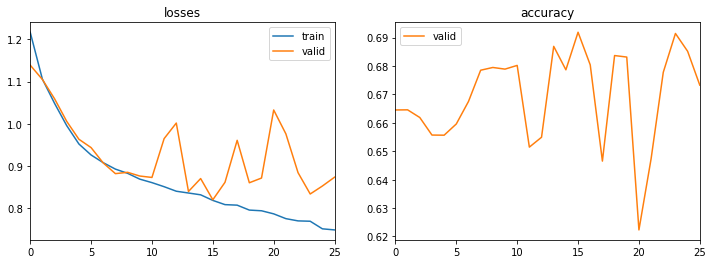

In [40]:
learn = build_model(best_parameters)

In [41]:
dls = learn.dls
valid_dl = dls.valid

In [42]:
time_steps = best_parameters["time_steps"]
X_test_tmp = X_test[:, :, -time_steps:]

In [43]:
test_ds = valid_dl.dataset.add_test(X_test_tmp, y_test)  # use the test data
test_dl = valid_dl.new(test_ds)
print(test_dl.n)

102430


In [44]:
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
test_probas, test_targets, test_preds

(tensor([[5.9078e-01, 2.9376e-01, 8.0885e-02, 2.8921e-02, 5.1085e-03, 5.5249e-04],
         [9.0976e-01, 6.1269e-02, 2.4966e-02, 3.4246e-03, 4.7618e-04, 1.0753e-04],
         [9.8564e-01, 1.2600e-02, 1.6188e-03, 1.3522e-04, 3.6975e-06, 5.9723e-07],
         ...,
         [9.9573e-01, 4.1015e-03, 1.5421e-04, 1.7044e-05, 1.0828e-06, 2.7286e-07],
         [9.8894e-01, 1.0359e-02, 6.5426e-04, 4.6382e-05, 3.1741e-06, 6.3660e-07],
         [9.6729e-01, 2.8267e-02, 4.0091e-03, 3.9349e-04, 3.5414e-05, 4.5907e-06]]),
 TensorCategory([1, 0, 0,  ..., 0, 0, 0], dtype=torch.int32),
 tensor([0, 0, 0,  ..., 0, 0, 0]))

In [45]:
print(f'accuracy: {skm.accuracy_score(test_targets, test_preds):10.6f}')
print(f'f1 score: {skm.f1_score(test_targets, test_preds, average="weighted"):10.6f}')

accuracy:   0.702734
f1 score:   0.695826


Save the true and predicted results:

In [46]:
y_test_true = test_targets.numpy()
y_test_pred = test_preds.numpy()

In [47]:
np.save('y_true_RNN_FCN', y_test_true)
np.save('y_pred_RNN_FCN', y_test_pred)